# Introduction

This a notebook detailing the programming of a predictive model that aims to predict under what conditions can a round of Counter Strike: Global Offensive be won. The modeling is done using a dataset obtained from `kaggle` named [CS:GO Round Winner Classification](https://www.kaggle.com/datasets/christianlillelund/csgo-round-winner-classification/data).

The working model can be found at [HuggingFace](https://huggingface.co/spaces/TRusso/CSGO_Round_Winner_Prediction?logs=build)

## What is CSGO?

Counter Strike: Global Offensive(CSGO) is an online competitive game where two teams of five players face off against each other to complete certain objectives such as planting/defusing a bomb, and rescuing hostages. The teams are split into Terrorists(T) and Counter-Terrorist(CT) where Ts need to plant a bomb in certain areas on the map to win, while CTs work to defuse said bomb before it explodes. Alternatively a team can completely kill the other team to win the round. A single match of CSGO is first-to-15 rounds, following tennis rules in case of tied round scores.

Each team is able to buy specific weapons before a round starts. These range from pistols, rifles, and grenades. It is accepted logic withing the community that most of the higher caliber weapons are better than lower ones. The guns themselves are direct copies of real life weapons. It is also important to note that some weapons are only available to certain teams. The only way for a team to obtain a weapon that is only purchasable by the enemy team is to steal them from killed enemies.  These specific weapons will be pointed out as they become relevant later on.

## Business Problem

An online esports betting site has hired us to create a predictive model that accurately forecasts the outcome of CSGO matches

## Dataset Description

| Column                        | Description                                                      |
|-------------------------------|------------------------------------------------------------------|
| time_left                     | Time remaining in the current round (in seconds)                 |
| ct_score                      | Counter-Terrorist team score                                     |
| t_score                       | Terrorist team score                                             |
| map                           | Name of the map being played                                     |
| bomb_planted                  | Indicates whether the bomb is planted or not                      |
| ct_health                     | Health of Counter-Terrorist team                                 |
| t_health                      | Health of Terrorist team                                         |
| ct_armor                      | Armor points of Counter-Terrorist team                           |
| t_armor                       | Armor points of Terrorist team                                   |
| ct_money                      | Money available for Counter-Terrorist team                       |
| t_money                       | Money available for Terrorist team                               |
| ct_helmets                    | Number of helmets bought for Counter-Terrorist team           |
| t_helmets                     | Number of helmets bought for Terrorist team                   |
| ct_defuse_kits                | Number of defuse kits bought for Counter-Terrorist team        |
| ct_players_alive              | Number of Counter-Terrorist team players alive                   |
| t_players_alive               | Number of Terrorist team players alive                           |
| ct_weapon_ak47                | Number of AK-47 weapons bought for Counter-Terrorist team     |
| t_weapon_ak47                 | Number of AK-47 weapons bought for Terrorist team             |
| ct_weapon_**X**               | Number of **X** weapons bought by Counter-Terrorist team         |
| t_weapon_**X**               | Number of **X** weapons bought by Terrorist team         |
| ct_grenade_hegrenade          | Number of HE grenades bought for Counter-Terrorist team       |
| t_grenade_hegrenade           | Number of HE grenades bought for Terrorist team               |
| ct_grenade_flashbang          | Number of flashbangs bought for Counter-Terrorist team        |
| t_grenade_flashbang           | Number of flashbangs bought for Terrorist team                |
| ct_grenade_smokegrenade       | Number of smoke grenades bought for Counter-Terrorist team    |
| t_grenade_smokegrenade        | Number of smoke grenades bought for Terrorist team            |
| ct_grenade_incendiarygrenade  | Number of incendiary grenades bought for Counter-Terrorist team | 
| t_grenade_incendiarygrenade   | Number of incendiary grenades bought for Terrorist team       |
| ct_grenade_molotovgrenade     | Number of molotov grenades bought for Counter-Terrorist team  |
| t_grenade_molotovgrenade      | Number of molotov grenades bought for Terrorist team          |
| ct_grenade_decoygrenade       | Number of decoy grenades bought for Counter-Terrorist team    |
| t_grenade_decoygrenade        | Number of decoy grenades bought for Terrorist team            |
| round_winner                  | Team that won the round (CT or T)                                |


For the sake of brevity, not all columns `ct_weapon_*X*` and `t_weapon_*X*` are marked here. Said columns simply describe how many of weapon *X* were bought each team.

# Import Libraries

In [3]:
# library dataframe
import pandas as pd
# library olah data numerical
import numpy as np
# library statistik
from scipy.stats import pearsonr, kendalltau, spearmanr

# Data visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# libraries Data Preprocessing
from sklearn.model_selection import train_test_split # splittingdata
from feature_engine.outliers import Winsorizer # outlier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler # scalling
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder # encoder
from imblearn.over_sampling import SMOTE # balancing

from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Library handling outlier
from feature_engine.outliers import Winsorizer

# Pemodelan ML
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Evaluasi model
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, precision_score, recall_score, f1_score,accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import SelectKBest


from collections import Counter

# lib pipelines
from sklearn.pipeline import Pipeline

# Save model
import pickle
import joblib
import json

# Library to suppress warnings or deprecation notes
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [56]:
df = pd.read_csv('csgo_round_snapshots.csv')

In [57]:
df.head(10)

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
5,114.97,1.0,0.0,de_dust2,False,500.0,500.0,500.0,0.0,1750.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,CT
6,94.97,1.0,0.0,de_dust2,False,295.0,111.0,296.0,0.0,1700.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
7,74.97,1.0,0.0,de_dust2,False,295.0,111.0,296.0,0.0,1700.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
8,54.97,1.0,0.0,de_dust2,False,249.0,89.0,269.0,0.0,2300.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
9,174.97,2.0,0.0,de_dust2,False,500.0,500.0,196.0,0.0,19800.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


In [58]:
df.tail(10)

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
122400,0.24,11.0,13.0,de_train,True,119.0,178.0,182.0,195.0,2300.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122401,174.93,11.0,14.0,de_train,False,500.0,500.0,176.0,177.0,11800.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122402,114.93,11.0,14.0,de_train,False,500.0,500.0,476.0,477.0,500.0,...,5.0,4.0,5.0,1.0,0.0,0.0,5.0,0.0,0.0,T
122403,94.93,11.0,14.0,de_train,False,500.0,500.0,476.0,477.0,500.0,...,2.0,3.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,T
122404,35.41,11.0,14.0,de_train,True,315.0,428.0,382.0,467.0,150.0,...,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122405,15.41,11.0,14.0,de_train,True,200.0,242.0,195.0,359.0,100.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122406,174.93,11.0,15.0,de_train,False,500.0,500.0,95.0,175.0,11500.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122407,114.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,4.0,3.0,5.0,1.0,0.0,0.0,5.0,0.0,0.0,T
122408,94.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,5.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,T
122409,74.93,11.0,15.0,de_train,False,375.0,479.0,395.0,466.0,1100.0,...,3.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,T


# EDA

In [7]:
print(f'Rows : {df.shape[0]}')
print(f'Columns : {df.shape[1]}')

Rows : 122410
Columns : 97


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122410 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     122410 non-null  float64
 1   ct_score                      122410 non-null  float64
 2   t_score                       122410 non-null  float64
 3   map                           122410 non-null  object 
 4   bomb_planted                  122410 non-null  bool   
 5   ct_health                     122410 non-null  float64
 6   t_health                      122410 non-null  float64
 7   ct_armor                      122410 non-null  float64
 8   t_armor                       122410 non-null  float64
 9   ct_money                      122410 non-null  float64
 10  t_money                       122410 non-null  float64
 11  ct_helmets                    122410 non-null  float64
 12  t_helmets                     122410 non-nul

Initial insights from info:

- dataset has `122410` rows spread across `97` columns
- Datatypes present are `float`, `object`, and `bool`

The target variable for modeling will be `round_winner`.

In [9]:
df.nunique()

time_left                    10782
ct_score                        33
t_score                         34
map                              8
bomb_planted                     2
                             ...  
ct_grenade_molotovgrenade        4
t_grenade_molotovgrenade         6
ct_grenade_decoygrenade          4
t_grenade_decoygrenade           3
round_winner                     2
Length: 97, dtype: int64

## Checking for Missing Values

<Axes: >

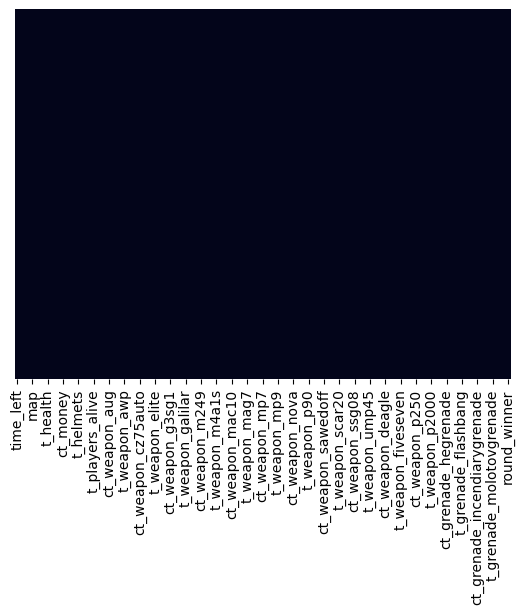

In [10]:
# Plot to show presence of null values
sns.heatmap(df.isna(),yticklabels=False ,cbar=False)

No missing values are present

## Checking for Duplicate Data

In [49]:
df.duplicated().sum()

4962

We see that there is significant duplicated data. However, based on domain knowledge, professional CSGO players have a tendency to purchase the same items and play the same way across multiple rounds in multiple matches. This adherence to repeating strategies and loadouts is what is referred to in the scene as the `**meta**` Therefore, these duplicates are naturally occuring and keeping them will improve the accuracy of our models.

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
time_left,122410.0,97.886922,54.465238,0.01,54.92,94.91,166.9175,175.0
ct_score,122410.0,6.709239,4.790362,0.00,3.00,6.00,10.0000,32.0
t_score,122410.0,6.780435,4.823543,0.00,3.00,6.00,10.0000,33.0
ct_health,122410.0,412.106568,132.293290,0.00,350.00,500.00,500.0000,500.0
t_health,122410.0,402.714500,139.919033,0.00,322.00,500.00,500.0000,600.0
...,...,...,...,...,...,...,...,...
t_grenade_incendiarygrenade,122410.0,0.019819,0.143933,0.00,0.00,0.00,0.0000,3.0
ct_grenade_molotovgrenade,122410.0,0.048011,0.227669,0.00,0.00,0.00,0.0000,3.0
t_grenade_molotovgrenade,122410.0,1.352095,1.663246,0.00,0.00,1.00,2.0000,5.0
ct_grenade_decoygrenade,122410.0,0.027694,0.169531,0.00,0.00,0.00,0.0000,3.0


In [12]:
df.nunique().sort_values(ascending=False)

time_left               10782
t_money                  1399
ct_money                 1360
t_health                  502
ct_health                 501
                        ...  
t_weapon_m249               1
ct_weapon_g3sg1             1
ct_weapon_r8revolver        1
ct_weapon_sawedoff          1
ct_weapon_bizon             1
Length: 97, dtype: int64

We see the presence of constant columns, these columns will be removed as they will reduce the performance of the models.

## Checking Distribution of Target Variable

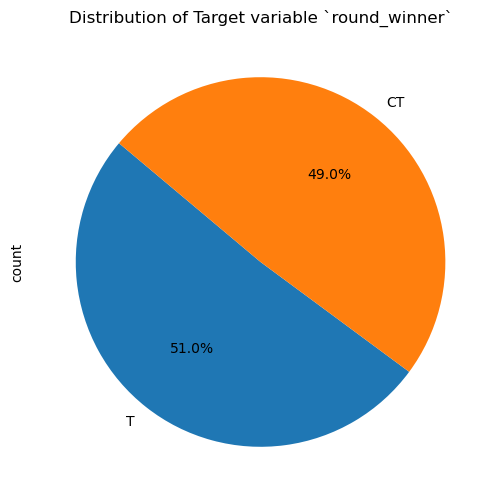

In [16]:
# Distribution of round_winner
plt.figure(figsize=(8,6))
df['round_winner'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Target variable `round_winner`')
plt.show()

Upon visual inspection, the dataset appears to balanced. Therefore, no balancing techniques will be performed before modelling.
We also see that T wins marginally more often than CT. This could indicate that the game contains inherent advantages for the teams playing on T side.

## Relationship between `map` and `round_winner`

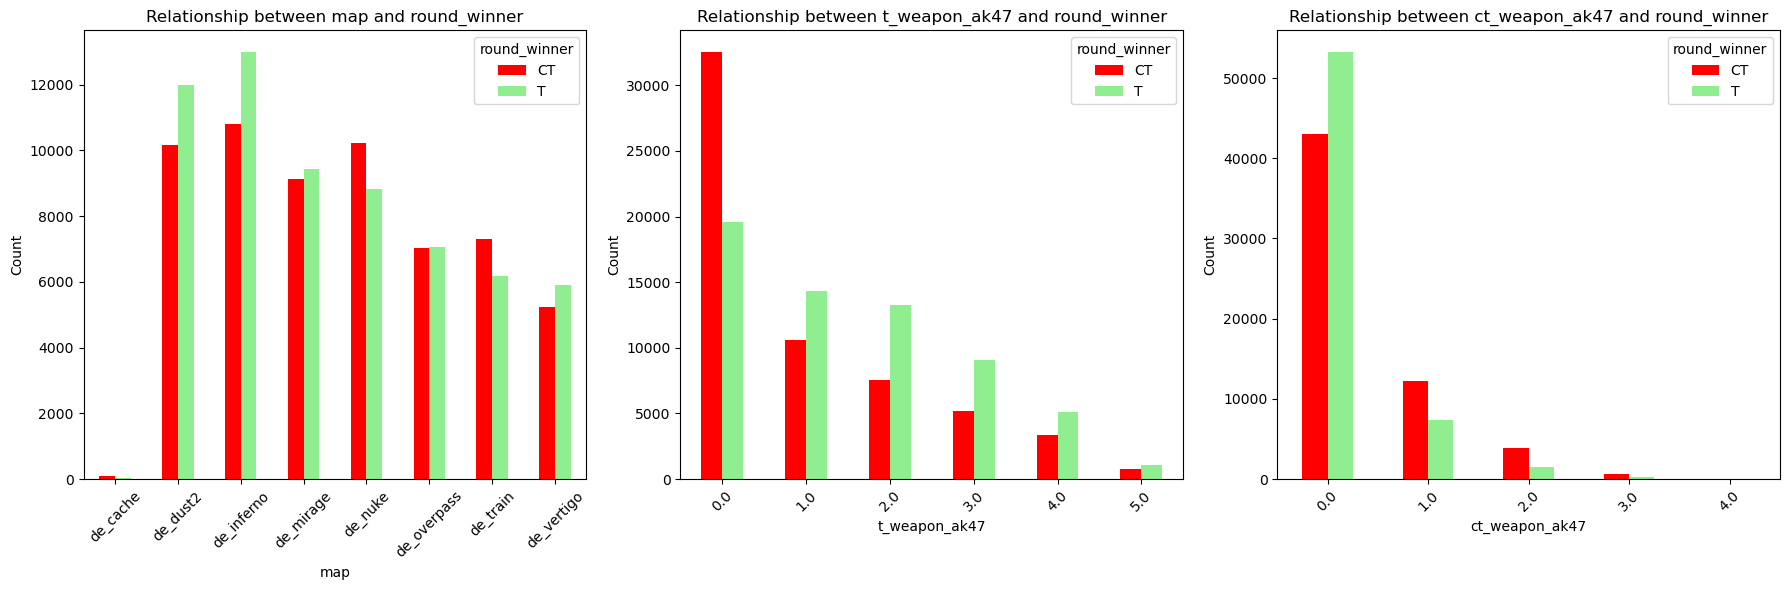

In [83]:
categorical = ['map', 't_weapon_ak47', 'ct_weapon_ak47']

# Calculate the number of plots needed based on the number of categorical features
num_plots = len(categorical)

# Calculate the number of rows and columns for the subplots
num_rows = (num_plots - 1) // 3 + 1
num_cols = min(num_plots, 3)

# Create a figure and axis array for subplots with larger figsize
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 6 * num_rows))

# Flatten the axes array to simplify iteration
axes = axes.flatten()

for i, x in enumerate(categorical):
    # Crosstab and plot
    cross_table = pd.crosstab(df[x], df['round_winner'])
    cross_table.plot(kind='bar', stacked=False, color=['red', 'lightgreen'], ax=axes[i])

    # Add labels and title
    axes[i].set_xlabel(x)
    axes[i].set_ylabel('Count')
    axes[i].set_title(f"Relationship between {x} and round_winner")
    axes[i].legend(title='round_winner', labels=['CT', 'T'])  # Custom legend labels

    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


- This plot shows that `round_winner` seems to depend significantly on `map`. This can happen for several reasons:
    - Certain maps within CSGO are known to be more advantageous to one team over the other due various factors such as verticality, choke-points, sight lines, etc.
    - The nature of CSGO dictates that Ts have to attack into CTs. This means that CTs have to play more reactively than proactively, giving the initiative to Ts.
    - As mentioned before, the game does favor T over CT in most cases. This is reinforced by the plot showing that have higher T wins outnumber maps with more CT wins.
- The next two plots illustrate how important weapons are in CSGO.
    - Having a single AK47 instantly shifts the power over to the team that has it
    - the AK47 is a T-only weapon, which explains why there are fewer entries in `ct_weapon_ak47`
    - CTs win far more when no T has an AK47
    - Thes two plots go some way in explaining why Ts win more rounds overall.


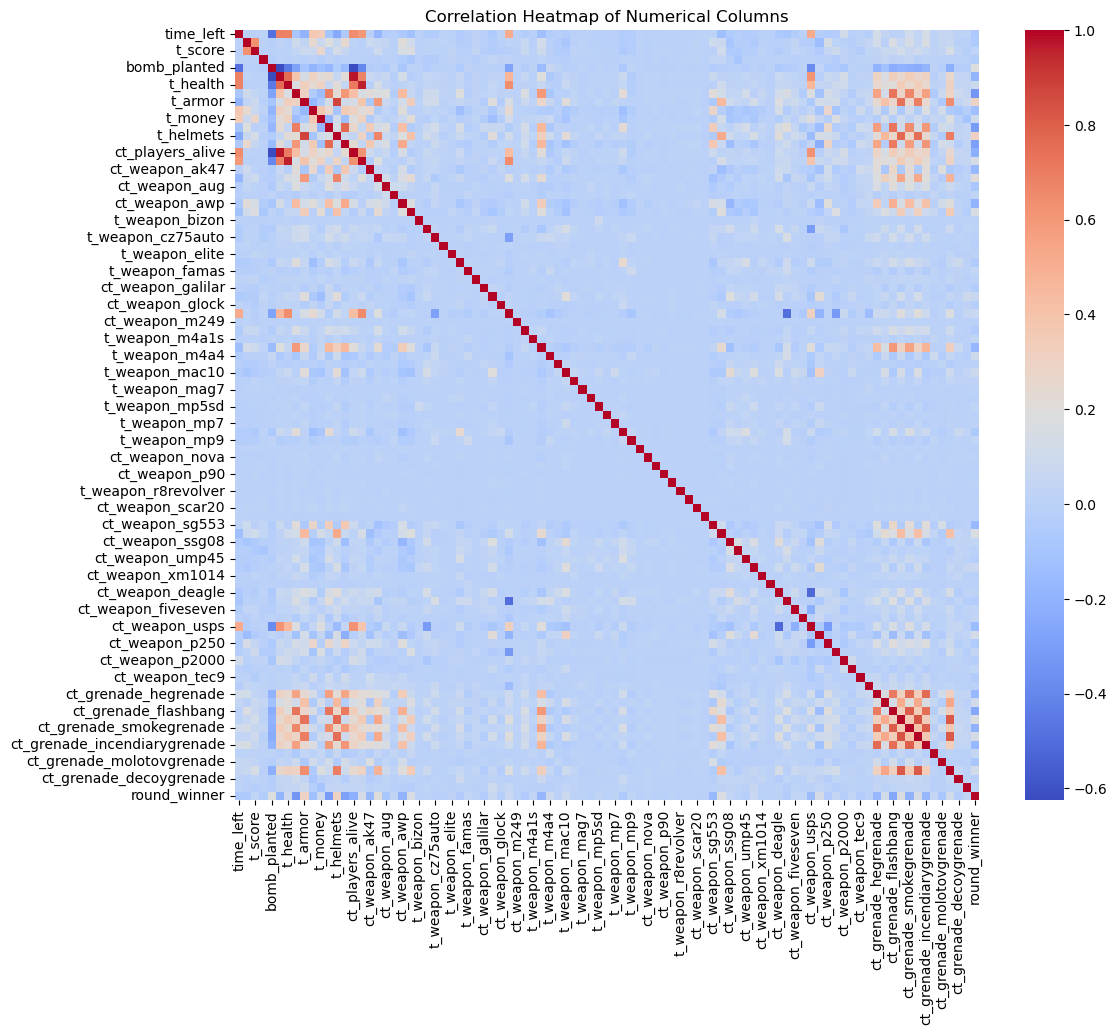

In [74]:
correlation_matrix = cs_df.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")

# Add title
plt.title('Correlation Heatmap of Numerical Columns')

# Show plot
plt.show()

We see from this heatmap that it seems that most of the features here don't correlate with one another. A notable exception is that grenade purchases seem to have correlation with the enemy team's available money. 

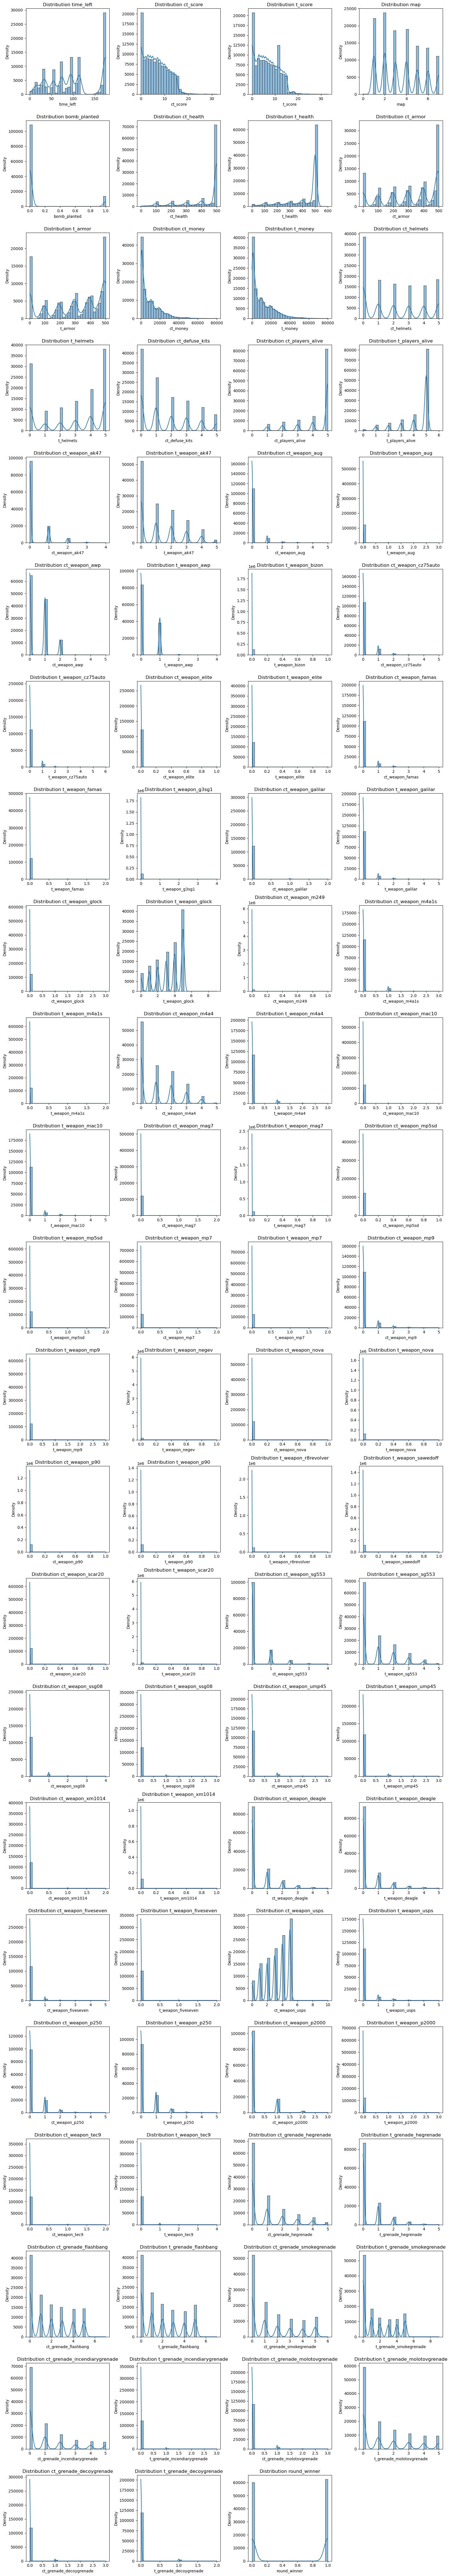

In [52]:

# Create the subplot grid based on the number of columns in the DataFrame
num_cols = len(df.columns)
num_rows = (num_cols + 3) // 4  # Calculate number of rows needed, rounding up
fig, axes = plt.subplots(num_rows, 4, figsize=(4 * 4, 4 * num_rows))

# Flatten axes array
axes = axes.flatten()

# Plotting each column
for i, col in enumerate(df.columns):
    sns.histplot(df[col], ax=axes[i], bins=30, kde=True) 
    axes[i].set_title(f'Distribution {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
   

# Erasing excess subplots
for j in range(num_cols, len(axes)):
    axes[j].remove()

# Display
plt.tight_layout()
plt.show()


In [14]:
df['round_winner'].value_counts()

round_winner
T     62406
CT    60004
Name: count, dtype: int64

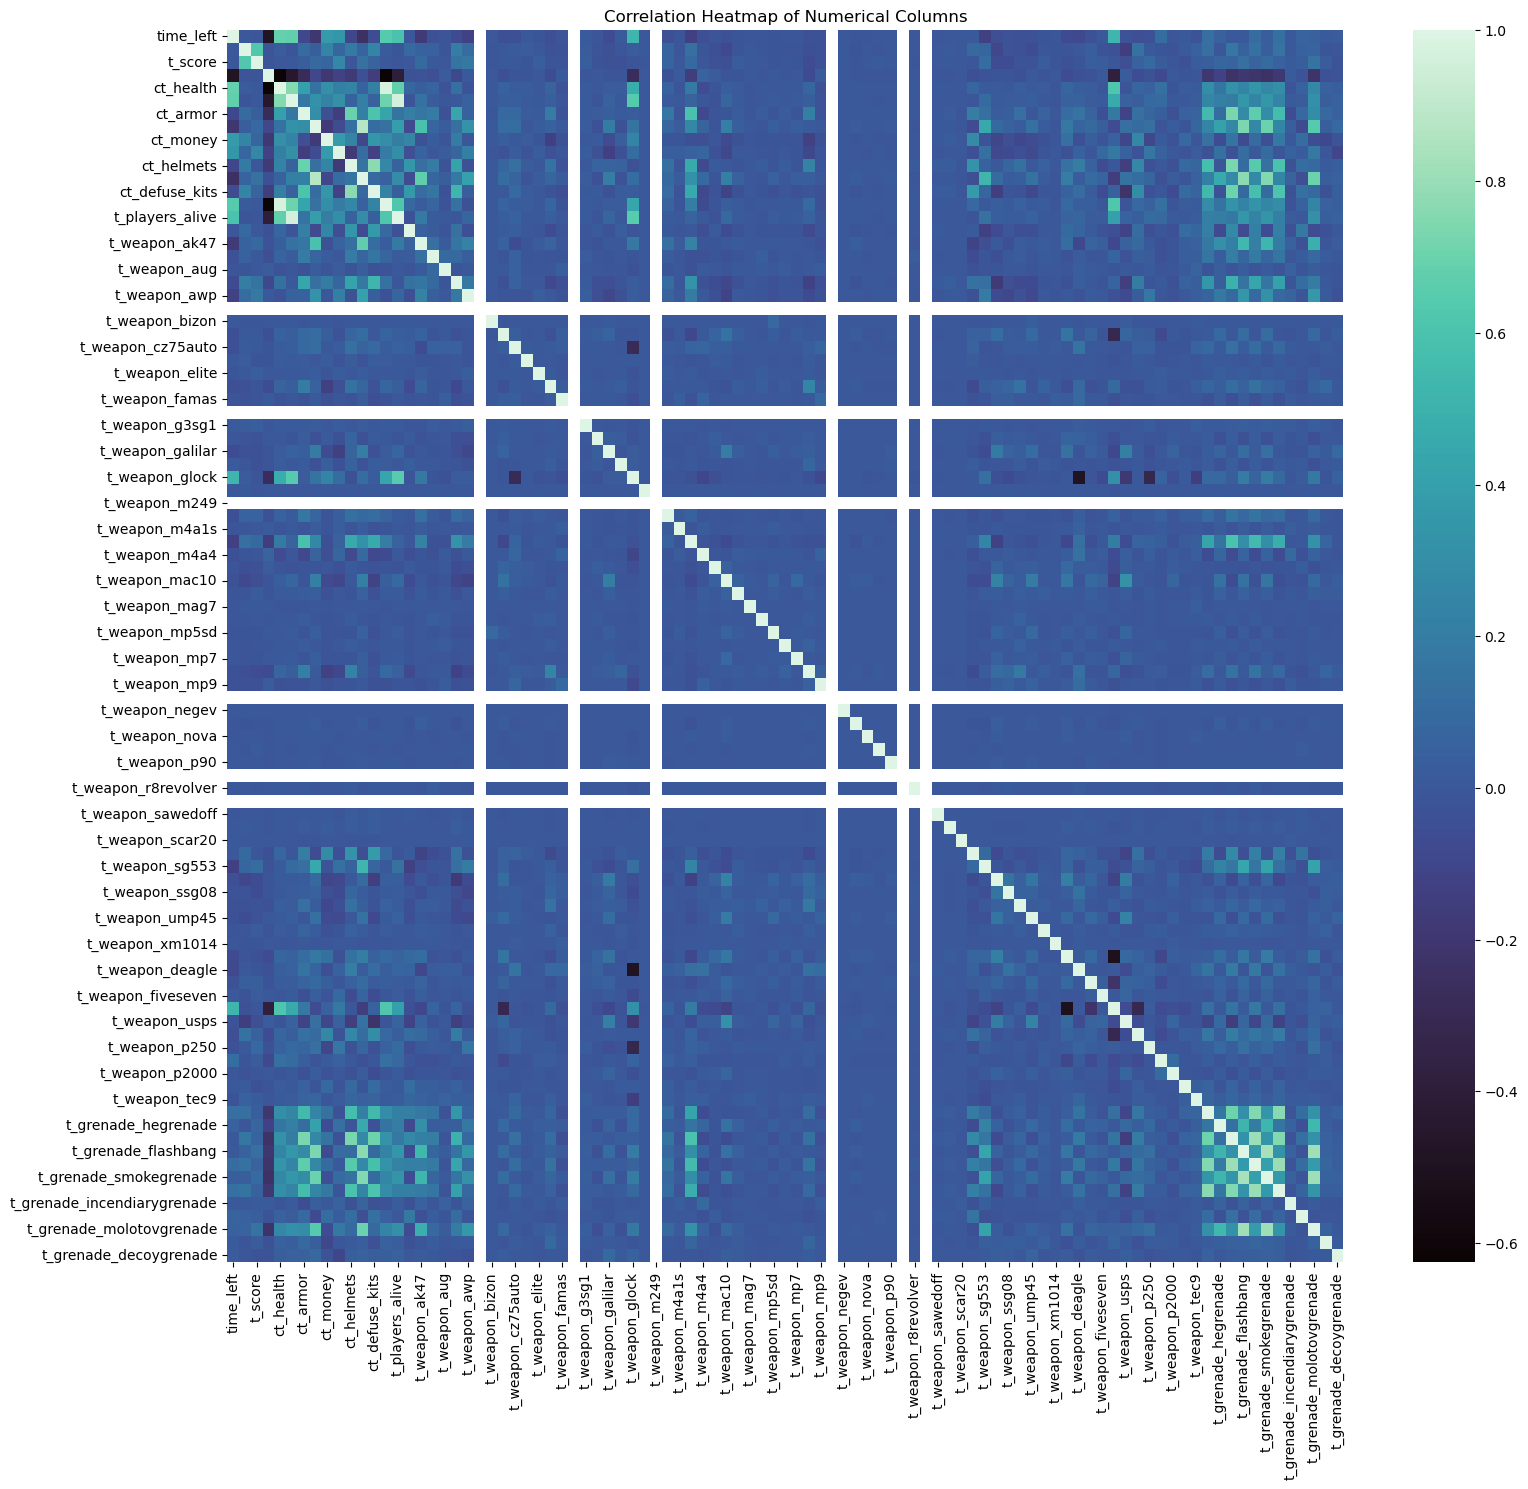

In [15]:
heat_df = df.drop(columns=['round_winner', 'map']) # Dropping categorical data for plotting heatmap
correlation_matrix = heat_df.corr()

# Create the heatmap
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, cmap='mako', fmt=".2f")

# Add title
plt.title('Correlation Heatmap of Numerical Columns')

# Show plot
plt.show()

# Preprocessing

We begin preprocessing by dropping all columns with only 1 value. We do this because the values in these columns will increase the complexity of the model and offer no variance. Removing these columns will also improve model performance by eliminating non-relevant features.

In [17]:
# Defining columns in dataset
col = df.columns

In [18]:
# checking for columns for only one value
single_value_cols=[]
for i in col:
    single_value_cols.append(df[i].nunique())

In [19]:
# all the columns with only one value
temp =[]
for i in range(len(single_value_cols)):
    if single_value_cols[i]==1:
        temp.append(i)
        print(i)

22
30
37
52
58
60


This is a list of all constant columns

In [20]:
# Dropping constant columns
df.drop([col[22], col[30], col[37], col[52], col[58], col[60]], axis = 1, inplace = True)

We drop all single value columns as they offer no variance and won't affect the model's performance.

## Encoding

We will be using `LabelEncoder` to encode all categorical values for modeling.

In [21]:
# Initialize the LabelEncoder
encoder = LabelEncoder()

df['round_winner'] = encoder.fit_transform(df['round_winner'])
df['map'] = encoder.fit_transform(df['map'])
df['bomb_planted'] = encoder.fit_transform(df['bomb_planted'])

# Feature Engineering


After various checks, data is now ready for engineering

In [22]:
# Copying data for modeling
cs_df = df.copy()

## Splitting

In [23]:
cs_df

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,1,0,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,156.03,0.0,0.0,1,0,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,96.03,0.0,0.0,1,0,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,76.03,0.0,0.0,1,0,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,174.97,1.0,0.0,1,0,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,14.0,6,1,200.0,242.0,195.0,359.0,100.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
122406,174.93,11.0,15.0,6,0,500.0,500.0,95.0,175.0,11500.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
122407,114.93,11.0,15.0,6,0,500.0,500.0,495.0,475.0,1200.0,...,4.0,3.0,5.0,1.0,0.0,0.0,5.0,0.0,0.0,1
122408,94.93,11.0,15.0,6,0,500.0,500.0,495.0,475.0,1200.0,...,5.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,1


In [24]:
# Define feature and target
X = cs_df.drop('round_winner', axis=1)
y = cs_df['round_winner']

In [25]:
# Spilt data training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

In [26]:
# cek ukuran
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print()
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (85687, 90)
y_train : (85687,)

X_test : (36723, 90)
y_test : (36723,)


Data has been successfuly split between train and test sets.

## Handling Outliers

We have no cause to remove s as they represent legitimate data points that occure naturally, albeit infrequently. Removing outliers would also remove extreme events or execptional gameplay situations that could provide crucial insights onto how rounds are won.

## Handling Missing Values

No missing values are present

## Splitting between Numerical and Categorical

- This step will be skipped for the following reasons:
    - Data has already been encoded during preprocessing
    - Modeling will be done locally and the dataset is massive relative to available computational resources. Skipping this step will reduce the load required during modeling
    - The models used such as `RandomForest` and `XGBoost` can automatically detect feature importance.

# Feature Selection

In [27]:
# Checking correlation in columns
p_values = []
interpretation = []
cols = []
corr = []

# iterating over all columns
for col in X_train.columns:
  if abs(X_train[col].skew()) < 0.5:                    #For Normally Distributed Columns
    corr_coef, p_value = pearsonr(X_train[col], y_train)

    p_values.append(p_value)
    cols.append(col)
    corr.append(corr_coef)

    if p_value < 0.05:
      interpretation.append('Significant Correlation')
    else :
      interpretation.append('No Significant Correlation')
  else:                                                     #For skewed Columns
    corr_coef, p_value = spearmanr(X_train[col], y_train)

    p_values.append(p_value)
    cols.append(col)
    corr.append(corr_coef)

    if p_value < 0.05:
      interpretation.append('Significant Correlation')
    else :
      interpretation.append('No Significant Correlation')

dfCorrNum = pd.DataFrame({'Column Name':cols,
              'Correlation Coefficient' : corr,
              'P-value':p_values,
              'Interpretation': interpretation })

dfCorrNum

,Column Name,Correlation Coefficient,P-value,Interpretation
0,time_left,-0.069643,1.346705e-92,Significant Correlation
1,ct_score,-0.064120,9.356161e-79,Significant Correlation
2,t_score,0.028628,5.214263e-17,Significant Correlation
3,map,-0.040603,1.328947e-32,Significant Correlation
4,bomb_planted,0.183104,0.000000e+00,Significant Correlation
...,...,...,...,...
85,t_grenade_incendiarygrenade,0.054051,1.832443e-56,Significant Correlation
86,ct_grenade_molotovgrenade,-0.081886,2.189393e-127,Significant Correlation
87,t_grenade_molotovgrenade,0.135039,0.000000e+00,Significant Correlation
88,ct_grenade_decoygrenade,-0.020805,1.123920e-09,Significant Correlation


In [28]:
# Extracting high correlation columns
corrNum = dfCorrNum[dfCorrNum['Interpretation'] == 'Significant Correlation']
corrNum

,Column Name,Correlation Coefficient,P-value,Interpretation
0,time_left,-0.069643,1.346705e-92,Significant Correlation
1,ct_score,-0.064120,9.356161e-79,Significant Correlation
2,t_score,0.028628,5.214263e-17,Significant Correlation
3,map,-0.040603,1.328947e-32,Significant Correlation
4,bomb_planted,0.183104,0.000000e+00,Significant Correlation
...,...,...,...,...
85,t_grenade_incendiarygrenade,0.054051,1.832443e-56,Significant Correlation
86,ct_grenade_molotovgrenade,-0.081886,2.189393e-127,Significant Correlation
87,t_grenade_molotovgrenade,0.135039,0.000000e+00,Significant Correlation
88,ct_grenade_decoygrenade,-0.020805,1.123920e-09,Significant Correlation


In [29]:
# extract data
list_corrNum = list(corrNum['Column Name'].values)
list_corrNum

['time_left',
 'ct_score',
 't_score',
 'map',
 'bomb_planted',
 'ct_health',
 't_health',
 'ct_armor',
 't_armor',
 'ct_money',
 't_money',
 'ct_helmets',
 't_helmets',
 'ct_defuse_kits',
 'ct_players_alive',
 't_players_alive',
 'ct_weapon_ak47',
 't_weapon_ak47',
 'ct_weapon_aug',
 't_weapon_aug',
 'ct_weapon_awp',
 't_weapon_awp',
 't_weapon_cz75auto',
 'ct_weapon_elite',
 't_weapon_elite',
 'ct_weapon_famas',
 't_weapon_famas',
 't_weapon_g3sg1',
 'ct_weapon_galilar',
 't_weapon_galilar',
 'ct_weapon_glock',
 't_weapon_glock',
 'ct_weapon_m4a1s',
 't_weapon_m4a1s',
 'ct_weapon_m4a4',
 't_weapon_m4a4',
 't_weapon_mac10',
 'ct_weapon_mag7',
 'ct_weapon_mp5sd',
 't_weapon_mp5sd',
 't_weapon_mp7',
 'ct_weapon_mp9',
 't_weapon_mp9',
 't_weapon_nova',
 'ct_weapon_p90',
 't_weapon_r8revolver',
 'ct_weapon_sg553',
 't_weapon_sg553',
 'ct_weapon_ssg08',
 'ct_weapon_ump45',
 't_weapon_ump45',
 'ct_weapon_xm1014',
 'ct_weapon_fiveseven',
 't_weapon_fiveseven',
 'ct_weapon_usps',
 't_weapon_u

In [30]:
len(list_corrNum)

73

Total features selcted is 73.

In [31]:
# Storing selected features
selected_num_col = list_corrNum



X_train = X_train[selected_num_col]


X_test = X_test[selected_num_col]

In [77]:
cs_df.to_csv('encoded_cs_df.csv')

In [33]:
X_train

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
66240,54.89,8.0,12.0,1,0,300.0,277.0,289.0,300.0,2400.0,...,1.0,3.0,0.0,3.0,1.0,0.0,0.0,2.0,0.0,0.0
101693,114.91,2.0,0.0,1,0,500.0,500.0,477.0,500.0,13300.0,...,5.0,3.0,5.0,4.0,4.0,0.0,0.0,2.0,0.0,0.0
30473,164.94,11.0,11.0,3,0,500.0,500.0,475.0,200.0,5200.0,...,4.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0
9562,166.90,10.0,5.0,4,0,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121695,54.95,6.0,7.0,1,0,500.0,500.0,500.0,487.0,4950.0,...,2.0,2.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25015,14.93,12.0,4.0,4,0,273.0,252.0,262.0,200.0,1150.0,...,2.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
9818,86.91,6.0,2.0,3,0,295.0,412.0,298.0,481.0,2750.0,...,2.0,2.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0
69577,174.92,2.0,1.0,1,0,500.0,500.0,282.0,381.0,21500.0,...,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122059,174.93,3.0,0.0,6,0,500.0,500.0,53.0,0.0,26700.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Features successfully selected

## Scaling

In [34]:
#Inisialisasi MinMaxScaler
scaler = StandardScaler()

#Fit_transform untuk X_train, transform untuk X_test
X_train_scaled = scaler.fit_transform(X_train) ## hanya fit X_train
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled)


[[-0.78929008  0.26634727  1.07551084 ...  0.38880953 -0.16458231
  -0.15790121]
 [ 0.31289955 -0.98226213 -1.40382978 ...  0.38880953 -0.16458231
  -0.15790121]
 [ 1.23163575  0.89065198  0.86889912 ... -0.81362747  5.70903879
  -0.15790121]
 ...
 [ 1.41490554 -0.98226213 -1.19721806 ... -0.81362747 -0.16458231
  -0.15790121]
 [ 1.41508918 -0.77416056 -1.40382978 ... -0.81362747 -0.16458231
  -0.15790121]
 [-1.52310377  1.30685511 -0.16415947 ...  0.38880953 -0.16458231
  -0.15790121]]


## Encoding

Data has already been encoded during preprocessing

## Concate

In [35]:

# Transform into dataframe
X_train_final = pd.DataFrame(X_train_scaled)
X_test_final = pd.DataFrame(X_test_scaled)

In [36]:
X_train_final.head(10)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,-0.789290,0.266347,1.075511,-1.306321,-0.354873,-0.848432,-0.897904,-0.149330,0.008707,-0.659572,...,-0.481996,0.634930,-0.887724,0.749295,-0.001075,-0.139399,-0.209573,0.388810,-0.164582,-0.157901
1,0.312900,-0.982262,-1.403830,-1.306321,-0.354873,0.663185,0.694753,0.950468,1.153509,0.311447,...,1.775034,0.634930,1.989786,1.295709,2.060859,-0.139399,-0.209573,0.388810,-0.164582,-0.157901
2,1.231636,0.890652,0.868899,-0.270665,-0.354873,0.663185,0.694753,0.938768,-0.563693,-0.410136,...,1.210776,-1.036044,1.414284,-0.889949,2.060859,-0.139399,-0.209573,-0.813627,5.709039,-0.157901
3,1.267629,0.682550,-0.370771,0.247163,-0.354873,0.663185,0.694753,-1.839976,-1.708495,-0.517037,...,-1.046254,-1.036044,-0.887724,-0.889949,-0.688386,-0.139399,-0.209573,-0.813627,-0.164582,-0.157901
4,-0.788188,-0.149856,0.042452,-1.306321,-0.354873,0.663185,0.694753,1.085017,1.079097,-0.432407,...,0.082261,0.077939,-0.887724,-0.889949,1.373548,-0.139399,-0.209573,0.990028,-0.164582,-0.157901
5,-1.219919,0.890652,0.662287,1.800647,2.817912,-1.347266,-0.890762,-0.354079,-0.019913,0.703418,...,-0.481996,-1.036044,0.263280,-0.889949,-0.001075,-0.139399,-0.209573,-0.813627,-0.164582,-0.157901
6,-1.287865,-1.398465,-1.403830,1.282819,2.817912,-0.984478,-2.876226,-0.669979,-1.708495,-0.757565,...,-1.046254,-1.036044,-0.887724,-0.889949,-0.688386,-0.139399,-0.209573,-0.813627,-0.164582,-0.157901
7,-0.421098,-1.190364,-1.197218,1.282819,-0.354873,0.663185,-0.076579,1.079167,0.787172,-0.655118,...,0.646519,1.191922,0.263280,0.749295,-0.001075,-0.139399,-0.209573,0.990028,-0.164582,-0.157901
8,0.312900,-0.357957,-0.783995,-1.306321,-0.354873,0.663185,0.694753,1.067467,1.153509,0.471799,...,1.210776,1.748913,1.989786,1.842124,1.373548,-0.139399,-0.209573,1.591247,-0.164582,-0.157901
9,1.415456,-0.566059,-0.370771,-0.270665,-0.354873,0.663185,0.694753,-1.839976,-1.164714,-0.009256,...,-1.046254,-1.036044,-0.887724,-0.343535,-0.688386,-0.139399,-0.209573,-0.813627,-0.164582,-0.157901


# Model Definition

The models that will be used are:
- `XGBoost`
- `KNN`
- `SVC`
- `RandomForest`
- `DecisionTree`


In [37]:
# base models
base_xgb = XGBClassifier()
base_knn = KNeighborsClassifier()
base_tree = DecisionTreeClassifier()
base_svc = SVC()
base_Rf = RandomForestClassifier()


# Model Training

## Pipeline

### Random Forest

Random Forest is a versatile ensemble learning method that consists of a collection of decision trees. It is known for its simplicity, scalability, and effectiveness in both classification and regression tasks. Random Forest builds multiple decision trees during training and combines their predictions through voting (classification) or averaging (regression) to improve overall accuracy and robustness. It reduces overfitting by randomly selecting subsets of features and data samples for each tree. Random Forest offers several hyperparameters for tuning model performance, including:

- Number of Trees: Determines the number of decision trees in the forest.
- Maximum Depth: Limits the depth of each tree to control model complexity.
- Maximum Features: Controls the number of features considered for splitting at each node.
- Minimum Samples Split: Specifies the minimum number of samples required to split a node.
- Bootstrap Samples: Controls whether to use bootstrapping for sample selection.

In [71]:
# Define your preprocessing steps
preprocessor = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
])

# Define your classifiers
classifiers = {
    'RandomForest': RandomForestClassifier()
    #'XGBoost': XGBClassifier(),
    #'KNN': KNeighborsClassifier(),
    #'SVC': SVC(),
    #'DecisionTree': DecisionTreeClassifier()
}

# Create separate pipelines for each classifier
pipelines = {}
for name, classifier in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    pipelines[name] = pipeline

# Evaluate each model using cross-validation and calculate accuracy and F1 score
for name, pipeline in pipelines.items():
    # Cross-validation scores
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    
    # Check for overfitting
    pipeline.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, pipeline.predict(X_train))
    val_accuracy = np.mean(cv_scores)
    overfitting_difference = train_accuracy - val_accuracy
    
    # Make predictions on test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate accuracy and F1 score on test set
    test_accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Print results
    print(f"Results for {name}:")
    print(f"Cross-Validation Accuracy: {val_accuracy:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Overfitting Difference: {overfitting_difference:.4f}")
    print("="*50)


Results for RandomForest:
Cross-Validation Accuracy: 0.8565
Training Accuracy: 0.9971
Test Accuracy: 0.8691
Test F1 Score: 0.8692
Overfitting Difference: 0.1406


### XGB

XGBoost is a powerful gradient boosting algorithm that is widely used in machine learning competitions and industry applications. It is highly effective in handling both regression and classification tasks, particularly in structured/tabular data. XGBoost utilizes an ensemble of decision trees and employs a gradient boosting framework to sequentially improve the model's performance. It provides excellent predictive accuracy and is robust to overfitting due to regularization techniques and early stopping. XGBoost offers various hyperparameters to fine-tune the model, including:

- Learning Rate: Controls the contribution of each tree in the ensemble.
- Maximum Depth: Limits the depth of each tree to control model complexity.
- Number of Trees: Specifies the number of boosting rounds.
- Regularization Parameters: Controls overfitting by penalizing complex models.
- Subsampling Parameters: Controls the fraction of data and features used for each boosting round.

In [70]:
# Define your preprocessing steps
preprocessor = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
])

# Define your classifiers
classifiers = {
    #'RandomForest': RandomForestClassifier()
    'XGBoost': XGBClassifier()
    #'KNN': KNeighborsClassifier(),
    #'SVC': SVC(),
    #'DecisionTree': DecisionTreeClassifier()
}

# Create separate pipelines for each classifier
pipelines = {}
for name, classifier in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    pipelines[name] = pipeline

for name, pipeline in pipelines.items():
    # Cross-validation scores
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    
    # Check for overfitting
    pipeline.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, pipeline.predict(X_train))
    val_accuracy = np.mean(cv_scores)
    overfitting_difference = train_accuracy - val_accuracy
    
    # Make predictions on test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate accuracy and F1 score on test set
    test_accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Print results
    print(f"Results for {name}:")
    print(f"Cross-Validation Accuracy: {val_accuracy:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Overfitting Difference: {overfitting_difference:.4f}")
    print("="*50)


Results for XGBoost:
Cross-Validation Accuracy: 0.7963
Training Accuracy: 0.8406
Test Accuracy: 0.8015
Test F1 Score: 0.8015
Overfitting Difference: 0.0443


### KNN


KNN (K-Nearest Neighbors) is a simple and easy-to-understand algorithm, suitable as a baseline in modeling. It is non-parametric, meaning it is not limited to a specific distribution, and can be used without a training process, making it fast and suitable for regular data updates. This model has several hyperparameters as follows:

- n_neighbors = Number of neighbors (k)
- p = Distance between data points
- weights = Weights of each neighbor for making predictions

In [69]:
# Define your preprocessing steps
preprocessor = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
])

# Define your classifiers
classifiers = {
    #'RandomForest': RandomForestClassifier()
    #'XGBoost': XGBClassifier(),
    'KNN': KNeighborsClassifier()
    #'SVC': SVC(),
    #'DecisionTree': DecisionTreeClassifier()
}

# Create separate pipelines for each classifier
pipelines = {}
for name, classifier in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    pipelines[name] = pipeline

# Evaluate each model using cross-validation and calculate accuracy and F1 score
for name, pipeline in pipelines.items():
    # Cross-validation scores
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    
    # Check for overfitting
    pipeline.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, pipeline.predict(X_train))
    val_accuracy = np.mean(cv_scores)
    overfitting_difference = train_accuracy - val_accuracy
    
    # Make predictions on test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate accuracy and F1 score on test set
    test_accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Print results
    print(f"Results for {name}:")
    print(f"Cross-Validation Accuracy: {val_accuracy:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Overfitting Difference: {overfitting_difference:.4f}")
    print("="*50)


Results for KNN:
Cross-Validation Accuracy: 0.8059
Training Accuracy: 0.8962
Test Accuracy: 0.8196
Test F1 Score: 0.8196
Overfitting Difference: 0.0903


### SVC

SVM (Support Vector Machine) is an effective algorithm in high-dimensional feature spaces and handles non-linear data well using kernel functions. It also has adjustable penalty parameters for flexibility in handling varying data. This algorithm has several hyperparameters such as:
- C = Inverse of regularization strength
- Kernel = Kernel used in SVC

In [47]:
# Define your preprocessing steps
preprocessor = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
])

# Define your classifiers
classifiers = {
    #'RandomForest': RandomForestClassifier()
    #'XGBoost': XGBClassifier(),
    #'KNN': KNeighborsClassifier(),
    'SVC': SVC()
    #'DecisionTree': DecisionTreeClassifier()
}

# Create separate pipelines for each classifier
pipelines = {}
for name, classifier in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    pipelines[name] = pipeline

# Evaluate each model using cross-validation and calculate accuracy and F1 score
for name, pipeline in pipelines.items():
    # Cross-validation scores
    cv_scores = cross_val_score(pipeline, X_train_final, y_train, cv=5, scoring='accuracy')
    # Fit the pipeline
    pipeline.fit(X_train_final, y_train)
    # Make predictions
    y_pred = pipeline.predict(X_test_final)
    # Calculate accuracy and F1 score on test set
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Print results
    print(f"Results for {name}:")
    print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print("="*50)


Results for SVC:
Cross-Validation Accuracy: 0.7810
Test Accuracy: 0.7863
Test F1 Score: 0.7860


### Decision Tree

Decision Tree is a simple yet powerful supervised learning algorithm that is widely used for classification and regression tasks. It recursively partitions the feature space into regions based on feature values to make predictions. Each internal node of the tree represents a decision based on a feature, and each leaf node represents a class label or a numeric value. Decision Tree is intuitive, easy to interpret, and capable of capturing complex decision boundaries. However, it is prone to overfitting, especially with deep trees. Decision Tree offers various hyperparameters to control its growth and complexity, including:

- Maximum Depth: Limits the depth of the tree to prevent overfitting.
- Minimum Samples Split: Specifies the minimum number of samples required to split a node.
- Minimum Samples Leaf: Specifies the minimum number of samples required to be a leaf node.
- Criterion: Determines the quality of a split (e.g., Gini impurity or entropy).


In [68]:
# Define your preprocessing steps
preprocessor = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
])

# Define your classifiers
classifiers = {
    #'RandomForest': RandomForestClassifier()
    #'XGBoost': XGBClassifier(),
    #'KNN': KNeighborsClassifier(),
    #'SVC': SVC(),
    'DecisionTree': DecisionTreeClassifier()
}

# Create separate pipelines for each classifier
pipelines = {}
for name, classifier in classifiers.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    pipelines[name] = pipeline

# Evaluate each model using cross-validation and calculate accuracy and F1 score
for name, pipeline in pipelines.items():
    # Cross-validation scores
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    
    # Check for overfitting
    pipeline.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, pipeline.predict(X_train))
    val_accuracy = np.mean(cv_scores)
    overfitting_difference = train_accuracy - val_accuracy
    
    # Make predictions on test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate accuracy and F1 score on test set
    test_accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Print results
    print(f"Results for {name}:")
    print(f"Cross-Validation Accuracy: {val_accuracy:.4f}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Overfitting Difference: {overfitting_difference:.4f}")
    print("="*50)


Results for DecisionTree:
Cross-Validation Accuracy: 0.7971
Training Accuracy: 0.9971
Test Accuracy: 0.8146
Test F1 Score: 0.8147
Overfitting Difference: 0.2001


Best model is Random Forest

# Model Evaluation

| Model          | Cross-Validation Accuracy | Test Accuracy | Test F1 Score |
|----------------|---------------------------|---------------|---------------|
| RandomForest  |           0.8556          |     0.8691    |     0.8692    |
| XGBoost        |           0.7963          |     0.8015    |     0.8015    |
| KNN            |           0.8059          |     0.8195    |     0.8195    |
| SVC            |           0.7810          |     0.7863    |     0.7860    |
| DecisionTree   |           0.7974          |     0.8138    |     0.8138    |


Based on the result of training, we see that the `RandomForest` model significantly outscores all other models at a score of 0.85 on cross validation. All models are only marginally overfitting. As all other models are didn't perform as well, we will be moving to tuning using the `RandomForest` model.

## Hyperparameter Tuning the Best Model

We will be using `RandomizedSearchCV` for tuning as computational resources are limited on the current device. 

In [43]:
# Define your preprocessing steps
preprocessor = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features by removing the mean and scaling to unit variance
])

# Define Random Forest classifier
random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Define hyperparameter grid for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Perform hyperparameter tuning using RandomizedSearchCV
random_forest_search = RandomizedSearchCV(random_forest_pipeline, param_distributions=param_grid_rf, n_iter=10, cv=5, scoring='accuracy', random_state=42)

# Fit the Random Forest pipeline
random_forest_search.fit(X_train, y_train)

# Make predictions
y_pred_rf = random_forest_search.predict(X_test)

# Calculate accuracy and F1 score on test set
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Print results
print("Results for Random Forest with Hyperparameter Tuning:")
print(f"Best Parameters: {random_forest_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {random_forest_search.best_score_:.4f}")
print(f"Test Accuracy: {accuracy_rf:.4f}")
print(f"Test F1 Score: {f1_rf:.4f}")


Results for Random Forest with Hyperparameter Tuning:
Best Parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': None, 'classifier__bootstrap': False}
Best Cross-Validation Accuracy: 0.8604
Test Accuracy: 0.8726
Test F1 Score: 0.8727


# Model Saving

In [85]:

# Save the trained model pipeline
with open('tuned_random_forest_pipeline.pkl', 'wb') as f1:
    pickle.dump(random_forest_search, f1)

print("Model saved successfully.")

Model saved successfully.


# Model Inference

separate notebook

# Conclusion

## EDA Conclusions

- Key insights gained from EDA:
    - There is a close to even spread between T round wins and CT round wins. The dataset can be described as equal.
    - Correlation heatmap indicates that most of the features do not have strong correlation with one another. To get a more accurate analysis, a comprehensive correlation analysis will be done in feature engineering.

## Model Conclusions

- 5 models (`KNN, SVC, RandomForest, XGB, DecisionTree`) were tested in this notebook. Of the 5, `RandomForest` yielded the best performance
- The metric that we will be paying attention to in this analysis is accuracy since the data is balanced, and F1 score as we are looking for the model that correctly identifies instances across all classes. The model that scored the highest here is `RandomForest` with accuracy of `0.8691` and F1 score of `0.8692`.
- Model can be used with randomly generated data based on the required features.

## Business Recommendation

- Final model performance sits at approximately 86% accuracy. Bookmakers should use this value to establish proper odds for the user base to start betting. Keep in mind that the odds still need to favor the house overall to ensure profitability.
- The model should still be reevaluated and improved over time to ensure ongoing performance.